In [23]:
from matplotlib import pyplot as plt
import numpy as np
import mido as md
import os

## Preprocessing of the data

In [24]:
def midiTrackToNoteSequence(track, timeSignature, mid):
    sequence = []
    notes = {}
    prevTime = 0.0
    for msg in track:
        if msg.is_meta:
            if msg.type == "time_signature":
                timeSignature["numerator"] = msg.numerator
                timeSignature["denominator"] = msg.denominator
            elif msg.type == "set_tempo":
                usPerQuarter = msg.tempo
                sPerQuarter = usPerQuarter / 1e6
                timeSignature["tempo"] = 60 / sPerQuarter * \
                    timeSignature["denominator"] /4
        else:
            time = msg.time / mid.ticks_per_beat * \
                60 / timeSignature["tempo"] + \
                prevTime
            
            if msg.type == "note_on" or msg.type =="note_off":

                note = {
                    "channel": msg.channel,
                    "note": msg.note,
                    "velocity": msg.velocity,
                    "time": time,
                    "end": -1
                }
                key = "{:02}_{:03}".format(msg.channel, msg.note)

                if msg.type == "note_on":
                    if not key in notes:
                        notes[key] = []
                    else: 
                        prevNote = notes[key][-1]

                        if prevNote["end"] < 0:
                            prevNote["end"] = time

                    notes[key].append(note)
                else:
                    if key in notes:
                        prevNote = notes[key][-1]

                        prevNote["end"] = time

            prevTime = time

    for key in notes.keys():
        for note in notes[key]:
            noteLength = 1.0

            if note["end"] >= 0.0:
                noteLength = note["end"] - note["time"]

            sequence.append({
                "time": note["time"],
                "number": note["note"],
                "length": noteLength
            })

    sequence.sort(key = lambda note: note["time"])

    return sequence

def findTrackName(track):
    for msg in track:
        if msg.type == "track_name":
            return msg.name
    return None

def printTrackNames(midiFilename):
    mid = md.MidiFile(midiFilename)

    print("Tracks in {}:".format(midiFilename))

    for track in mid.tracks:
        print("\t{}".format(findTrackName(track)))

def readMidiFileIntoPointSet(filename, trackName = None, singleNote = False):
    mid = md.MidiFile(filename)

    timeSignature = {
        "numerator": 4,
        "denominator": 4,
        "tempo": 60
    }

    noteTimes = []
    noteNumbers = []
    noteLengths = []

    sequence = []

    for track in mid.tracks:
        if trackName:
            currentName = findTrackName(track)

            if currentName != trackName:
                continue

        sequence.extend(midiTrackToNoteSequence(track, timeSignature, mid))

    sequence.sort(key = lambda note: note["time"])

    SMALL_DT = 0.01

    for note in sequence:
        if singleNote and len(noteTimes) > 0:
            if note["time"] - noteTimes[-1] < SMALL_DT:
                continue

        
        noteTimes.append(note["time"])
        noteNumbers.append(note["number"])
        noteLengths.append(note["length"])

    return {
        "t": np.array(noteTimes),
        "n": np.array(noteNumbers),
        "l": np.array(noteLengths),
        "timeSignature": timeSignature
    }

## Normalisation of score

In [25]:
def consistent_normalize_score(score, scale_max=10000):
    # Ensure the estimated maximum score is not zero to avoid division by zero
    if scale_max == 0:
        return 0  # Optionally adjust based on your context
    # Normalize the score
    normalized_score = (score / scale_max) * 100
    # Ensure the normalized score does not exceed 100
    normalized_score = min(normalized_score, 100)
    normalized_score = max(normalized_score, 0)
    
    return normalized_score

## Algorithm development and experimentation

In [26]:
def proportionalTransportationDistance(set_A, set_B):
    w = set_A["l"] #note weights
    u = set_B["l"]

    W = w.sum()
    U = u.sum()

    t1 = (set_A["t"] - set_A["t"].min()) / (set_A["t"].max() - set_A["t"].min())
    t2 = (set_B["t"] - set_B["t"].min()) / (set_B["t"].max() - set_B["t"].min())
    p1 = set_A["n"] - (set_A["n"] * w/W).sum()
    p2 = set_B["n"] - (set_B["n"] * u/U).sum()

    f = w.reshape(-1, 1) * u.reshape(1, -1)/U
    d = np.sqrt(
        9 * (t1.reshape(-1, 1) - t2.reshape(1, -1)) ** 2 +
        (p1.reshape(-1, 1) - p2.reshape(1, -1)) ** 2
    )
    return (f*d).sum() / W

def otherDistance(set_A, set_B):
    w = set_A["l"] / set_A["l"].sum()
    u = set_B["l"] / set_B["l"].sum()

    t1 = (set_A["t"] - set_A["t"].min()) / (set_A["t"].max() - set_A["t"].min())
    t2 = (set_B["t"] - set_B["t"].min()) / (set_B["t"].max() - set_B["t"].min())
    p1 = set_A["n"] - (set_A["n"] * w).sum()
    p2 = set_B["n"] - (set_B["n"] * u).sum()

    f = w.reshape(-1, 1) * u.reshape(1, -1)
    d = np.sqrt(
        (t1.reshape(-1, 1) - t2.reshape(1, -1)) ** 2 +
        (p1.reshape(-1, 1) - p2.reshape(1, -1)) ** 2
    )

    dargmin0 = d.argmin(axis=0)
    dargmin1 = d.argmin(axis=1)

    dmin0 = d[dargmin0, :]
    dmin1 = d[:, dargmin1]
    fmin0 = f[dargmin0, :]
    fmin1 = f[:, dargmin1]

    return (fmin0 * dmin0).sum() + (fmin1 * dmin1).sum()


def otherDistanceWeightLess(set_A, set_B):
   # Normalize times
    t1 = (set_A["t"] - set_A["t"].min()) / (set_A["t"].max() - set_A["t"].min())
    t2 = (set_B["t"] - set_B["t"].min()) / (set_B["t"].max() - set_B["t"].min())
    
    # Directly use pitches
    p1 = set_A["n"]
    p2 = set_B["n"]

    # Use lengths as part of the distance calculation
    # Ensure lengths are positively contributing to the distance
    l1 = set_A["l"] / np.max(set_A["l"])  # Normalize lengths in set_A
    l2 = set_B["l"] / np.max(set_B["l"])  # Normalize lengths in set_B

    # Calculate the base distance matrix considering time, pitch, and normalized lengths
    d_base = np.sqrt((t1.reshape(-1, 1) - t2.reshape(1, -1)) ** 2 + (p1.reshape(-1, 1) - p2.reshape(1, -1)) ** 2)
    
    # Introduce length differences into the distance calculation
    # The difference in lengths adds to the distance, making length discrepancies contribute directly
    d_length = np.abs(l1.reshape(-1, 1) - l2.reshape(1, -1))

    # Combine the base distance with the length distance
    d_combined = d_base + d_length

    # Compute the overall distance by summing the minimal distances from the combined matrix
    total_distance = np.min(d_combined, axis=0).sum() + np.min(d_combined, axis=1).sum()

    result = consistent_normalize_score(total_distance)
    return total_distance

## Calculating scores and displaying of results

PTD(SubMidi, SubMidi) = 0.0
PTD(1_single_eight_notes.mid, SubMidi) = 0.475
PTD(1_single_sixteenth_notes.mid, SubMidi) = 0.7124999999999999
PTD(1_single_whole_notes.mid, SubMidi) = 1.9988743371731579
PTD(2_Single_notes.mid, SubMidi) = 1.4479166666666667
PTD(3_single_notes.mid, SubMidi) = 2.8958333333333335
PTD(4_single_notes.mid, SubMidi) = 4.396529634581105
PTD(5_single_notes.mid, SubMidi) = 5.676174645390071
PTD(6_single_notes.mid, SubMidi) = 6.978485718492344
Minimum Score (Should Always be Subject MIDI): SubMidi: 0.0
2nd Minimum Score: 1_single_eight_notes.mid: 0.475


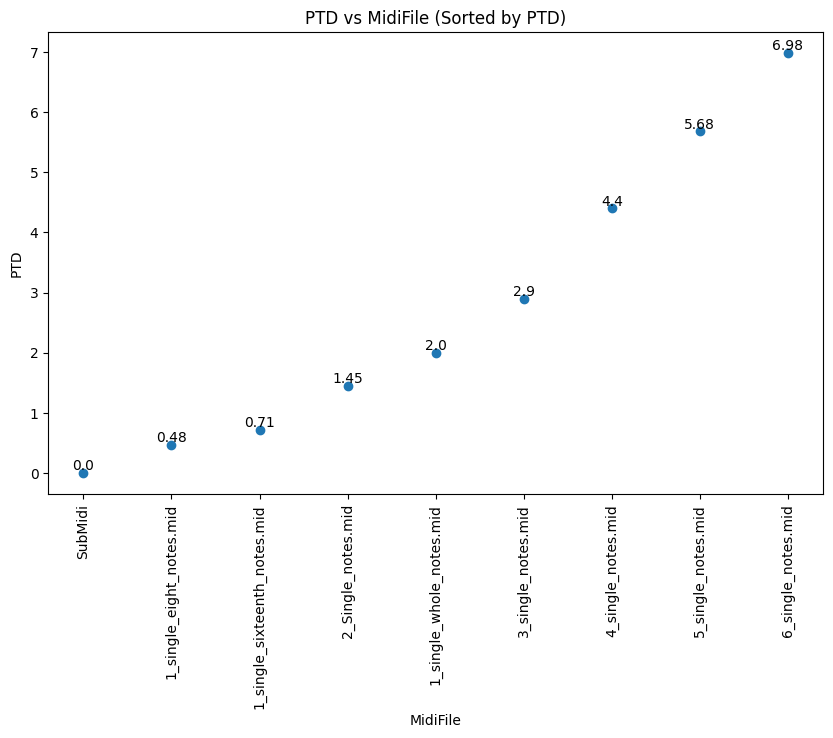

In [27]:

subMidi_folder_path = "SubjectMidiFile"
folder_path = "MIDITestDb"
sub_files_num = 0
subMidi_name = "SubMidi"
sets = {}

for sub_file_name in os.listdir(subMidi_folder_path):     #get subject file from Folder
    if sub_file_name.endswith(".mid") or sub_file_name.endswith(".midi"):
        sub_files_num += 1
        if(sub_files_num == 1):
            file_path = os.path.join(subMidi_folder_path, sub_file_name)
            SubjectMidi = readMidiFileIntoPointSet(file_path)
            # plt.figure()
            # plt.plot(SubjectMidi["t"], SubjectMidi["n"], '.')
            setToAdd = {
                subMidi_name: SubjectMidi
            }
            sets.update(setToAdd)

for file_name in os.listdir(folder_path):     #get Midi files from dataset folder
    if file_name.endswith(".mid") or file_name.endswith(".midi"):
        file_path = os.path.join(folder_path, file_name)
        midi_data = readMidiFileIntoPointSet(file_path)
        # plt.figure()
        # plt.plot(midi_data["t"], midi_data["n"], '.')
        setToAdd = {
            file_name: midi_data
        }
        sets.update(setToAdd)
        
min_score=999999999.99
second_min_score = 0.0
min_score_file=""
second_min_score_file=""

key_A_values = []
PTD_values = []

for key_A in sets.keys():
    PTD = otherDistanceWeightLess(sets[key_A], sets[subMidi_name])
    print("PTD({}, {}) = {}".format(key_A, subMidi_name, PTD))

    if PTD < min_score:
        second_min_score = min_score 
        min_score = PTD
        second_min_score_file = min_score_file  
        min_score_file = key_A
    elif PTD < second_min_score:
        second_min_score = PTD
        second_min_score_file = key_A

    key_A_values.append(key_A)
    PTD_values.append(PTD)

print("==========================================================")
print("Minimum Score (Should Always be Subject MIDI): {}: {}".format(min_score_file, min_score)) #smallest PTD should be the subMidi to itself (ideal: 0)
print("2nd Minimum Score: {}: {}".format(second_min_score_file, second_min_score)) #second smallest PTD is the most similiar Midi file in the Database


plotData = list(zip(key_A_values, PTD_values)) #plotting of the data
sorted_data = sorted(plotData, key=lambda x: x[1])
sorted_key_A_values, sorted_PTD_values = zip(*sorted_data)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(sorted_key_A_values, sorted_PTD_values)
ax.set_xlabel('MidiFile')
ax.set_ylabel('PTD')
ax.set_title('PTD vs MidiFile (Sorted by PTD)')
ax.set_xticks(sorted_key_A_values)
ax.set_xticklabels(sorted_key_A_values, rotation=90, ha='center')
for i, txt in enumerate(sorted_PTD_values):
    ax.text(sorted_key_A_values[i], txt, str(round(txt, 2)), ha='center', va='bottom')

plt.show()
